In [ ]:
import sys
import os
import importlib
import glob
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import pyemma
import msmtools
import mdtraj as md

import ivac
import extq

import jax
import jax.numpy as jnp
from jax import vmap, jit, grad

In [2]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [3]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [4]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

In [5]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [6]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")
sb_ids = [42, 48, 47, 53]

In [7]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [8]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [9]:
rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)
print(rf161_arr.shape)

(4150115, 3)


In [10]:
hb_trajs = list(np.load("../../data/raw_feat/hbonds.npy", allow_pickle=True))
hb_trajs.extend(np.load("../../data/raw_feat/hbonds_anton2.npy", allow_pickle=True))
hb_arr = np.concatenate(hb_trajs)
print(hb_arr.shape)

(4150115, 18)


In [11]:
sb_models = np.load("../../data/models_centroids_feat2.npy")

# States

In [12]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
# tic1 = livac_arr[:, 1]
# tic2 = livac_arr[:, 2]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [13]:
mask = ~(down_ids | up_ids)

# len(**_ids) is number of points in each state
down = sb_arr[down_ids]
up = sb_arr[up_ids]
other = sb_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [14]:
assert (
    np.count_nonzero(down_ids) + np.count_nonzero(up_ids) + np.count_nonzero(mask)
) == len(cv_arr)
print(f"Number of down structures:  {len(down)}")
print(f"Number of up structures:   {len(up)}")
print(f"Number of other structures: {len(other)}")

Number of down structures:  37852
Number of up structures:   5400
Number of other structures: 4106863


In [15]:
random.seed(123)

In [16]:
s = 10
N = len(cv_arr)
inds = random.sample(range(N), N // s)

# Coefficients

In [62]:
from extq.stop import forward_stop

In [69]:
def forward_committor_coeffs(basis, weights, in_domain, guess, lag, test_basis=None):
    if test_basis is None:
        test_basis = basis
    a = 0.0
    b = 0.0
    for x, y, w, d, g in zip(test_basis, basis, weights, in_domain, guess):
        assert np.all(w[-lag:] == 0.0)
        iy = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
        assert np.all(iy < len(d))
        wx = scipy.sparse.diags(w[:-lag]) @ x[:-lag]
        a += wx.T @ (y[iy] - y[:-lag])
        b -= wx.T @ (g[iy] - g[:-lag])
    coeffs = scipy.linalg.solve(a, b)
    return coeffs

In [63]:
d_down_arr = np.load("../../data/feat2_dist_du_anton2/dist_down_3.npy")
d_up_arr = np.load("../../data/feat2_dist_du_anton2/dist_up_3.npy")

In [64]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make guess
guess_down = (d_up_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)
guess_up = (d_down_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)

# make smoothing 0 at boundaries (down and up states)
smooth[~mask] = 0
# ensure homogeneous boundary conditions for guess
guess_up[up_ids] = 1
guess_up[down_ids] = 0
guess_down[down_ids] = 1
guess_down[up_ids] = 0

In [65]:
weights = np.load("../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)

In [67]:
basisF_arr = smooth * sb_arr
basisF = []
curr = 0
traj_lens = [len(t) for t in cv_trajs]
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    curr += t_len

basis_d = util.orthogonalize(basisF, weights[0])

In [68]:
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)
in_domain[0].shape

(10000,)

In [71]:
guessU = np.split(guess_up, traj_inds)

In [72]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
qp_coeffs = []
for (lag, com) in zip(lags, weights):
    qp_coeffs.append(forward_committor_coeffs(basis_d, com, in_domain, guessU, lag))

In [73]:
qp_coeffs[0].shape

(60, 1)

In [83]:
np.save("../../data/feat2_dist_du_anton2/qp_downup_3_coeffs.npy", qp_coeffs)

# Basis gradients

In [126]:
def orthogonal_coeffs(b, weights):
    numer = jnp.einsum('m,mi,mj->ij', weights, b, b)
    denom = jnp.sum(weights)
    evals, evecs = jnp.linalg.eigh(numer / denom)
    coeffs = evecs / jnp.sqrt(evals)[None, :]
    return coeffs

In [164]:
smooth = (d_down_arr * d_up_arr)**0.5 / (d_down_arr + d_up_arr)
smooth[~mask] = 0
basis = smooth * sb_arr
ortho_jit = jit(orthogonal_coeffs)
coeffs = orthogonal_coeffs(basis, np.concatenate(weights[0]))

In [142]:
coeffs.shape

(60, 60)

In [54]:
# dists = jax.jit(min_dist)(sb_trajs[0], down)
b = basis_jit(sb_trajs[0], down, up, None)
# b = basis(sb_trajs[0][:10], down, up, None)

In [55]:
b.shape

(10000, 60)

In [315]:
def min_dist(t, S):
    """Compute the minimum distance from each point in a array
    t to a set S
    """
    # d_S_all = jnp.linalg.norm(t[:, None, :] - S[None, :, :], axis=2)
    # d_S = jnp.min(d_S_all, axis=1)
    d_S_all = jnp.linalg.norm(t[:, None, :] - S, axis=2)
    d_S = jnp.min(d_S_all, axis=1)
    return d_S

min_dist_jit  = jit(min_dist)

In [179]:
def compute_basis(arr, A=down, B=up, weights=weights, coeffs=coeff_v2):
    """Compute the value of the basis functions at a given point arr
    """
    # compute distance to domain
    d_A = min_dist(arr, A)
    d_B = min_dist(arr, B)
    # print(d_A.shape)
    # print(d_B.shape)

    # smooth
    smooth = (d_A * d_B) ** 0.5 / (d_A + d_B)
    # print(smooth.shape)
    b = arr * smooth[:, None]
    
    # orthogonalize
    return b @ coeffs

basis_jit = jit(compute_basis)

In [87]:
def guess(arr, A, B):
    d_A = min_dist(arr, A)
    d_B = min_dist(arr, B)
    
    return (d_A**2) / (d_A**2 + d_B**2)

guess_jit = jit(guess)

In [238]:
v = qp_coeffs[0].T
x = sb_trajs[0][0:1]
b, grad_b = jax.jvp(compute_basis, (x,), (v,))

In [160]:
b0 = basis_jit(sb_trajs[0])

In [161]:
b0.shape

(10000, 60)

In [145]:
b.shape

(1, 60)

In [146]:
grad_b.shape

(1, 60)

In [181]:
b

DeviceArray([[ 1.378212  , -0.49609375,  0.812788  , -3.0998955 ,
              -0.19584656,  0.26005173,  0.15979767, -0.8566284 ,
               0.4294176 , -2.0637274 ,  0.19683361,  1.0099468 ,
              -0.1892662 ,  0.48405075,  0.40651703, -0.54350567,
               1.4276905 ,  1.3063717 ,  1.4536829 ,  0.15480232,
               0.5621462 ,  1.5493097 ,  0.23080063, -0.24594855,
               0.9988923 , -0.21640015, -0.45181084, -0.48373604,
               0.8019762 , -0.252491  , -0.15877151, -0.6894202 ,
              -1.088604  , -0.01202965,  0.8473339 ,  1.0710192 ,
              -0.951951  , -0.58827305,  1.0303276 , -0.51822853,
               0.643723  , -1.71943   , -1.3337193 ,  1.8875566 ,
               0.2463584 , -1.3588821 ,  1.7473927 ,  0.52288437,
               0.38111925,  0.00703621,  0.37672305, -0.40361595,
               0.86130714, -0.47414494, -0.33787394,  1.5089891 ,
              -0.4066884 , -1.4085906 ,  1.3592343 , -0.86736006]],         

In [182]:
grad_b

DeviceArray([[ 0.4691059 , -0.35460585, -0.13519537, -0.19079077,
              -0.6443812 , -0.3548476 , -0.5211461 , -0.20242909,
               0.22672258, -0.0388618 , -0.21366069,  0.16554427,
               0.30581284, -0.01081845, -0.27769393, -0.03908242,
               0.19355495, -0.1263751 , -0.7493019 , -0.2476453 ,
               0.17179763, -0.11948915, -0.0958595 , -0.16789167,
               0.20092818,  0.0983468 , -0.10542825,  0.04677039,
               0.392994  , -0.36902148, -0.06080228,  0.07817657,
               0.61689806,  0.31145984,  0.04440007,  0.24766628,
               0.34194323, -0.3789889 ,  0.15546241, -0.1071243 ,
               0.1113968 ,  0.06219959, -0.12430082, -0.03111179,
               0.23171267,  0.14727291,  0.03877341, -0.01705545,
               0.24638191,  0.00795618, -0.18566239,  0.04057118,
               0.0269397 ,  0.04773086,  0.06547268,  0.0278327 ,
              -0.01177213, -0.04137278,  0.00684687, -0.00428703]],         

## Check against real basis

In [183]:
basis[0]

array([0.4560023 , 0.46070176, 0.51945   , 0.8075636 , 0.79830307,
       0.61846584, 0.34165213, 0.6164688 , 0.5943088 , 0.52688843,
       0.5007295 , 0.3256458 , 0.4871669 , 0.7847342 , 0.78218645,
       0.56003726, 0.412786  , 0.27297568, 0.6063342 , 0.89033604,
       0.9347085 , 0.6885905 , 0.5037282 , 0.41324767, 0.7069587 ,
       0.98782015, 1.058924  , 0.7886124 , 0.62219805, 0.5632615 ,
       0.4344573 , 0.24898455, 0.41706803, 0.88267994, 1.011613  ,
       0.80445266, 0.14210428, 0.43692303, 0.42862055, 0.4967966 ,
       0.6531093 , 0.46069333, 0.39157537, 0.78883934, 0.7804333 ,
       0.31334093, 0.31727478, 0.14156695, 0.72562355, 1.0343187 ,
       1.1165614 , 0.7381289 , 0.542327  , 0.4451287 , 0.8608167 ,
       1.1406994 , 1.2585881 , 0.8938844 , 0.7391427 , 0.65815336],
      dtype=float32)

In [185]:
ortho_b = (basis @ coeff_v2)
ortho_b[0]

array([ 1.37821821, -0.49609239,  0.81279608, -3.09990368, -0.19587522,
        0.26004498,  0.15979475, -0.85663883,  0.42941911, -2.06373256,
        0.19684513,  1.00995129, -0.18927458,  0.48405071,  0.40652237,
       -0.54351219,  1.42769509,  1.30637371,  1.45368437,  0.15480035,
        0.56213575,  1.54930463,  0.23079227, -0.24594474,  0.99888849,
       -0.21639872, -0.45181449, -0.48373528,  0.80197443, -0.25249172,
       -0.15877353, -0.68942067, -1.08860814, -0.0120296 ,  0.84733152,
        1.07101815, -0.95195011, -0.58827079,  1.03032789, -0.51822927,
        0.64372218, -1.71942967, -1.33371903,  1.8875552 ,  0.24635891,
       -1.35888396,  1.74739327,  0.52288373,  0.38111886,  0.00703597,
        0.37672264, -0.40361513,  0.86130797, -0.47414541, -0.33787368,
        1.50898937, -0.40668842, -1.40859056,  1.35923441, -0.8673601 ])

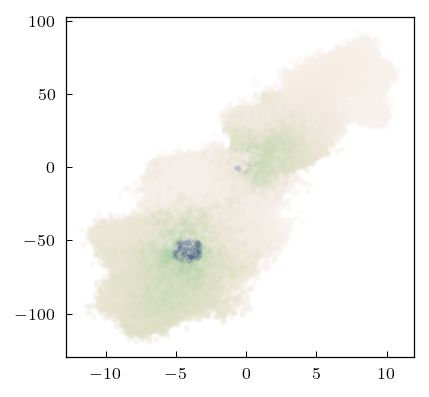

In [166]:
plt.scatter(cv_arr[inds,0], cv_arr[inds, 1], c=smooth[inds], alpha=0.2, cmap=cm_seq)

In [167]:
basisF_arr = smooth * sb_arr
basisF = []
curr = 0
traj_lens = [len(t) for t in cv_trajs]
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    curr += t_len

In [170]:
basis_d = util.orthogonalize(basisF, weights[0])
# basis_d = ortho_jit(np.concatenate(basisF), np.concatenate(weights[0]))

In [171]:
basis_d[0][0]

array([ 1.37821821, -0.49609239,  0.81279608, -3.09990368, -0.19587522,
        0.26004498,  0.15979475, -0.85663883,  0.42941911, -2.06373256,
        0.19684513,  1.00995129, -0.18927458,  0.48405071,  0.40652237,
       -0.54351219,  1.42769509,  1.30637371,  1.45368437,  0.15480035,
        0.56213575,  1.54930463,  0.23079227, -0.24594474,  0.99888849,
       -0.21639872, -0.45181449, -0.48373528,  0.80197443, -0.25249172,
       -0.15877353, -0.68942067, -1.08860814, -0.0120296 ,  0.84733152,
        1.07101815, -0.95195011, -0.58827079,  1.03032789, -0.51822927,
        0.64372218, -1.71942967, -1.33371903,  1.8875552 ,  0.24635891,
       -1.35888396,  1.74739327,  0.52288373,  0.38111886,  0.00703597,
        0.37672264, -0.40361513,  0.86130797, -0.47414541, -0.33787368,
        1.50898937, -0.40668842, -1.40859056,  1.35923441, -0.8673601 ])

In [175]:
def orthogonalize(basis, pi):
    numer = 0
    denom = 0
    for b, p in zip(basis, pi):
        numer += np.einsum("m,mi,mj->ij", p, b, b)
        denom += np.sum(p)
    evals, evecs = scipy.linalg.eigh(numer / denom)
    coeffs = evecs / np.sqrt(evals)[None, :]
    return coeffs

In [176]:
coeff_v2 = orthogonalize(basisF, weights[0])

In [177]:
coeff_v2

array([[-7.75815725e-01,  2.72481816e+01, -1.14793715e+01, ...,
        -1.29710829e-02, -1.23050271e-01, -2.22061586e-02],
       [-5.31095368e-01, -2.88699831e+01,  1.39164503e+00, ...,
         2.29537552e-01, -7.70634415e-02, -1.90278767e-02],
       [-2.82506291e+01,  1.93853133e+01, -2.20827818e+01, ...,
         2.05706419e-03, -3.34083331e-02, -2.08484552e-02],
       ...,
       [-1.63434460e+00,  6.39295338e+00,  4.84930703e+00, ...,
        -4.77709892e-01,  1.85601778e-01, -2.05028440e-02],
       [-3.68888258e-01, -3.49870644e+00, -5.53048316e+00, ...,
        -8.62340135e-01,  1.01509922e-01, -1.41377821e-02],
       [ 2.41119881e+00,  2.04148477e+00,  5.00465490e+00, ...,
        -5.54403945e-01,  1.86802337e-01, -1.18745385e-02]])

In [ ]:
np.save("../data/feat2_dist_

## JVP

In [223]:
def jvp(xs, v):
    return jax.jvp(compute_basis, (xs,), (v,))

In [250]:
x = sb_arr[0]
v = np.squeeze(qp_coeffs[0])
b, grad_b = jvp(x, v)

In [251]:
b

DeviceArray([[ 1.378212  , -0.49609375,  0.812788  , -3.0998955 ,
              -0.19584656,  0.26005173,  0.15979767, -0.8566284 ,
               0.4294176 , -2.0637274 ,  0.19683361,  1.0099468 ,
              -0.1892662 ,  0.48405075,  0.40651703, -0.54350567,
               1.4276905 ,  1.3063717 ,  1.4536829 ,  0.15480232,
               0.5621462 ,  1.5493097 ,  0.23080063, -0.24594855,
               0.9988923 , -0.21640015, -0.45181084, -0.48373604,
               0.8019762 , -0.252491  , -0.15877151, -0.6894202 ,
              -1.088604  , -0.01202965,  0.8473339 ,  1.0710192 ,
              -0.951951  , -0.58827305,  1.0303276 , -0.51822853,
               0.643723  , -1.71943   , -1.3337193 ,  1.8875566 ,
               0.2463584 , -1.3588821 ,  1.7473927 ,  0.52288437,
               0.38111925,  0.00703621,  0.37672305, -0.40361595,
               0.86130714, -0.47414494, -0.33787394,  1.5089891 ,
              -0.4066884 , -1.4085906 ,  1.3592343 , -0.86736006]],         

In [252]:
grad_b

DeviceArray([[ 0.4691059 , -0.35460585, -0.13519537, -0.19079077,
              -0.6443812 , -0.3548476 , -0.5211461 , -0.20242909,
               0.22672258, -0.0388618 , -0.21366069,  0.16554427,
               0.30581284, -0.01081845, -0.27769393, -0.03908242,
               0.19355495, -0.1263751 , -0.7493019 , -0.2476453 ,
               0.17179763, -0.11948915, -0.0958595 , -0.16789167,
               0.20092818,  0.0983468 , -0.10542825,  0.04677039,
               0.392994  , -0.36902148, -0.06080228,  0.07817657,
               0.61689806,  0.31145984,  0.04440007,  0.24766628,
               0.34194323, -0.3789889 ,  0.15546241, -0.1071243 ,
               0.1113968 ,  0.06219959, -0.12430082, -0.03111179,
               0.23171267,  0.14727291,  0.03877341, -0.01705545,
               0.24638191,  0.00795618, -0.18566239,  0.04057118,
               0.0269397 ,  0.04773086,  0.06547268,  0.0278327 ,
              -0.01177213, -0.04137278,  0.00684687, -0.00428703]],         

In [ ]:
def jvp_vec(xs, v):
    ans = np.zeros(N)
    ans_grad = np.zeros(N)
    for i, x in enumerate(xs):
        b, grad_b = jax.jvp(compute_basis, (x,), (v,))
        ans[i] = 

In [224]:
# vectorized over multiple points
jvp_vmap = vmap(jvp, in_axes=(0, None))
jvp_vmap_jit = jit(jvp_vmap, backend='cpu')

In [230]:
xs = sb_arr[:5000]
v = np.squeeze(qp_coeffs[0])
bs, grad_bs = jvp_vmap_jit(xs, v)

In [231]:
bs.shape

(5000, 1, 60)

In [232]:
grad_bs.shape

(5000, 1, 60)

In [233]:
np.squeeze(bs[0])

DeviceArray([ 1.3782014 , -0.49609587,  0.8127887 , -3.0999033 ,
             -0.19588509,  0.26004666,  0.15979852, -0.8566379 ,
              0.4294194 , -2.063728  ,  0.19683753,  1.0099556 ,
             -0.1892759 ,  0.4840504 ,  0.40651965, -0.54350734,
              1.4276904 ,  1.3063755 ,  1.4536827 ,  0.15479833,
              0.56213635,  1.5493093 ,  0.23079307, -0.2459463 ,
              0.9988867 , -0.21639982, -0.45181465, -0.4837359 ,
              0.80197394, -0.252492  , -0.1587745 , -0.68941903,
             -1.0886036 , -0.01202985,  0.84733367,  1.0710179 ,
             -0.95195115, -0.58827007,  1.0303279 , -0.51823175,
              0.6437239 , -1.7194295 , -1.3337195 ,  1.8875563 ,
              0.24635896, -1.3588858 ,  1.7473947 ,  0.52288455,
              0.38111684,  0.00703439,  0.37672135, -0.40361384,
              0.8613079 , -0.4741453 , -0.3378738 ,  1.5089891 ,
             -0.40668806, -1.4085907 ,  1.3592345 , -0.86736023],            dtype=float32

In [234]:
grad_bs[0]

DeviceArray([[ 0.46910593, -0.3546058 , -0.13519542, -0.19079095,
              -0.6443812 , -0.35484767, -0.5211461 , -0.20242913,
               0.22672264, -0.03886179, -0.21366067,  0.16554433,
               0.3058129 , -0.01081841, -0.27769396, -0.03908243,
               0.19355495, -0.12637505, -0.7493019 , -0.24764533,
               0.17179763, -0.11948919, -0.0958595 , -0.16789171,
               0.20092817,  0.09834678, -0.10542825,  0.04677038,
               0.39299387, -0.3690215 , -0.06080226,  0.07817658,
               0.61689806,  0.31145987,  0.0444001 ,  0.24766631,
               0.34194326, -0.37898892,  0.15546243, -0.10712429,
               0.1113968 ,  0.06219957, -0.12430078, -0.03111181,
               0.23171265,  0.14727296,  0.03877344, -0.01705545,
               0.2463819 ,  0.00795619, -0.1856624 ,  0.04057118,
               0.02693968,  0.04773086,  0.06547269,  0.0278327 ,
              -0.01177213, -0.04137278,  0.00684687, -0.00428703]],         

In [257]:
q = np.squeeze(bs[0]) @ qp_coeffs[0] + guess_up[:5000]

In [260]:
q.shape

(5000, 1)

## VJP

In [264]:
b.shape

(1, 60)

In [320]:
xs = sb_arr[:10]
x = sb_arr[0]
v = qp_coeffs[0]
# b, vjp_fun = jax.vjp(compute_basis, x)
b, vjp_fun = jax.vjp(compute_basis, xs)
# grad_b = vjp_fun(v.T)
grad_b = vjp_fun(np.tile(v, 10).T)

In [319]:
np.tile(v, 10).shape

(60, 10)

In [317]:
b[0]

DeviceArray([ 1.3782017 , -0.49612898,  0.812793  , -3.0999036 ,
             -0.19587183,  0.26004362,  0.15979624, -0.8566439 ,
              0.4294201 , -2.0637293 ,  0.19683301,  1.0099432 ,
             -0.1892685 ,  0.4840455 ,  0.4065199 , -0.5435059 ,
              1.42769   ,  1.3063639 ,  1.4536858 ,  0.15480018,
              0.56214285,  1.5493097 ,  0.23079205, -0.24594223,
              0.99888706, -0.21639633, -0.4518137 , -0.48373413,
              0.80197585, -0.2524886 , -0.15877461, -0.6894202 ,
             -1.088606  , -0.01202965,  0.84733224,  1.0710193 ,
             -0.9519501 , -0.58827186,  1.0303272 , -0.5182276 ,
              0.64372396, -1.7194304 , -1.3337188 ,  1.8875566 ,
              0.24635923, -1.3588809 ,  1.7473927 ,  0.52288496,
              0.38111877,  0.00703573,  0.37672275, -0.40361786,
              0.8613081 , -0.47414422, -0.33787382,  1.5089891 ,
             -0.40668833, -1.4085906 ,  1.3592343 , -0.86736006],            dtype=float32

In [324]:
grad_b[0].shape

(10, 60)

In [325]:
grad_b[0][0]

DeviceArray([-0.09353219,  0.04522399, -0.00898218,  0.00419281,
              0.00542474,  0.01667881, -0.06684671,  0.06184518,
              0.00113265,  0.024689  ,  0.0128451 , -0.06022443,
              0.14965126, -0.21895395,  0.14108609, -0.17071688,
              0.01487867, -0.00596779,  0.02385276,  0.06597949,
             -0.11931064,  0.02965443, -0.17589791,  0.17326443,
             -0.02789547,  0.06776278, -0.05184041,  0.06802508,
              0.10152201, -0.13517149,  0.04724414, -0.03149018,
              0.00514267, -0.02886754,  0.00296689,  0.00222514,
             -0.01721734,  0.06973054,  0.01050893,  0.04883461,
             -0.02902395,  0.0480562 ,  0.06440001, -0.05057526,
             -0.00632777, -0.04694576,  0.04292441, -0.10102909,
             -0.06701802,  0.00923637,  0.00539267,  0.07316626,
             -0.06700827,  0.05953629, -0.0024897 ,  0.05991712,
              0.03320385, -0.00112331,  0.07556533, -0.02500193],            dtype=float32

In [ ]:
vjp_vmap = vmap(vjp_fun, in_axes=(0

In [ ]:
vjp_vmap = vmap(vjp_fun)
grad_b = vjp_vmap(v[None,:])

In [288]:
def vectorize_vjp(xs, v, length=10):
    ans = np.zeros((length, 60))
    ans_grad = np.zeros((length, 60))
    for i, x in enumerate(xs):
        b, vjp_fun = jax.vjp(compute_basis, x)
        ans[i] = b
        ans_grad[i] = vjp_fun(v)

jitted_vjp = jit(vectorize_vjp, static_argnames='length', backend='cpu')

### vjp all

In [311]:
# jitted_vjp(xs, v.T, 10)
xs = sb_trajs[0]
ans = np.zeros_like(xs)
ans_grad = np.zeros_like(xs)
for i, x in enumerate(xs):
    b, vjp_fun = jax.vjp(compute_basis, x)
    ans[i] = b
    ans_grad[i] = np.squeeze(vjp_fun(v.T))

In [306]:
ans_grad[0]

array([-0.09353219,  0.04522398, -0.00898217,  0.00419282,  0.00542473,
        0.01667879, -0.0668467 ,  0.06184519,  0.00113265,  0.02468899,
        0.01284509, -0.06022444,  0.14965126, -0.21895397,  0.14108607,
       -0.17071687,  0.01487867, -0.00596777,  0.02385276,  0.0659795 ,
       -0.11931062,  0.02965443, -0.17589794,  0.17326443, -0.02789548,
        0.0677628 , -0.05184042,  0.06802508,  0.10152201, -0.13517147,
        0.04724414, -0.03149018,  0.00514267, -0.02886754,  0.00296689,
        0.00222515, -0.01721734,  0.06973055,  0.01050893,  0.0488346 ,
       -0.02902395,  0.0480562 ,  0.06440001, -0.05057523, -0.00632778,
       -0.04694575,  0.04292441, -0.10102909, -0.06701802,  0.00923637,
        0.00539267,  0.07316625, -0.06700827,  0.05953629, -0.0024897 ,
        0.05991712,  0.03320384, -0.00112332,  0.07556532, -0.02500193],
      dtype=float32)

In [312]:
ans.shape

(10000, 60)

In [313]:
ans_grad.shape

(10000, 60)

In [328]:
xs = sb_arr[:2000]
v = qp_coeffs[0]
b, vjp_fun = jax.vjp(compute_basis, xs)
# jitted_vjp_fun = jit(vjp_fun, backend='cpu')
grad_b = vjp_fun(np.tile(v, len(xs)).T)
# grad_b = jitted_vjp_fun(np.tile(v, len(xs)).T)

2022-03-31 11:45:09.382010: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.92GiB (rounded to 18168960000)requested by op 
2022-03-31 11:45:09.382291: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:491] *_*******************************************************___________________________________________
2022-03-31 11:45:09.382357: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2140] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 18168960000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   16.92GiB
              constant allocation:         0B
        maybe_live_out allocation:   17.48GiB
     preallocated temp allocation:        16B
                 total allocation:   34.41GiB
              total fragmentation:        28B (0.00%)
Peak bu

RuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 18168960000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   16.92GiB
              constant allocation:         0B
        maybe_live_out allocation:   17.48GiB
     preallocated temp allocation:        16B
                 total allocation:   34.41GiB
              total fragmentation:        28B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 16.92GiB
		Entry Parameter Subshape: f32[2000,37852,60]
		==========================

	Buffer 2:
		Size: 16.92GiB
		XLA Label: copy
		Shape: f32[2000,37852,60]
		==========================

	Buffer 3:
		Size: 288.79MiB
		Operator: op_name="jit(jvp(norm))/jit(main)/div" source_file="/scratch/local/jobs/3748629/ipykernel_3900620/939008017.py" source_line=7
		XLA Label: fusion
		Shape: f32[2000,37852]
		==========================

	Buffer 4:
		Size: 288.79MiB
		Operator: op_name="jit(jvp(norm))/jit(main)/div" source_file="/scratch/local/jobs/3748629/ipykernel_3900620/939008017.py" source_line=7
		XLA Label: fusion
		Shape: f32[2000,37852]
		==========================

	Buffer 5:
		Size: 24B
		XLA Label: tuple
		Shape: (f32[2000,37852], f32[2000,37852], f32[2000,37852,60])
		==========================

	Buffer 6:
		Size: 16B
		Operator: op_name="jit(jvp(norm))/jit(main)/div" source_file="/scratch/local/jobs/3748629/ipykernel_3900620/939008017.py" source_line=7
		XLA Label: fusion
		Shape: (f32[2000,37852], f32[2000,37852])
		==========================

	Buffer 7:
		Size: 4B
		XLA Label: parameter
		Shape: f32[]
		==========================

	Buffer 8:
		Size: 4B
		XLA Label: parameter
		Shape: f32[]
		==========================

	Buffer 9:
		Size: 4B
		Operator: op_name="jit(jvp(norm))/jit(main)/reduce_sum[axes=(2,)]" source_file="/scratch/local/jobs/3748629/ipykernel_3900620/939008017.py" source_line=7
		XLA Label: add
		Shape: f32[]
		==========================

